# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

Load feature names.

In [2]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape



(7000L, 126L) (1124L, 126L)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [4]:
def P1():
### STUDENT START ###
    pca = PCA()
    pca.fit(train_data)
    print(pca.explained_variance_ratio_[0:50])
### STUDENT END ###

P1()

[ 0.16404331  0.13323479  0.10173457  0.07063356  0.03866646  0.03680804
  0.03128239  0.02733737  0.0261649   0.02230943  0.02048173  0.01868331
  0.01734422  0.01684361  0.01518819  0.01508618  0.01429134  0.01412013
  0.01325045  0.01146379  0.01071066  0.01065747  0.01040967  0.00993699
  0.0090807   0.00869326  0.00795617  0.00775825  0.0073757   0.00700276
  0.00641233  0.00614513  0.00572345  0.00533629  0.00525936  0.00502674
  0.00499042  0.00455942  0.00452784  0.00439788  0.00419489  0.00397702
  0.00370043  0.00359528  0.00338124  0.00298987  0.00272031  0.00235706
  0.00221399  0.00204452]


(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

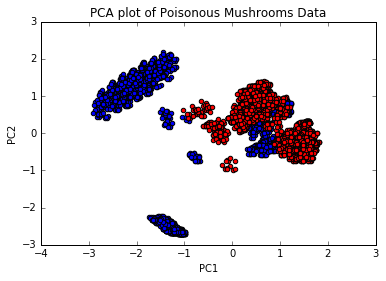

In [5]:
def P2():
### STUDENT START ###
    pca = PCA(n_components=2)
    # Transform to 2D projection data for plotting
    reduced_cartesian = pca.fit_transform(train_data)
    reduced_cartesian_poison = reduced_cartesian[train_labels == 1]
    reduced_cartesian_safe   = reduced_cartesian[train_labels == 0]
    
    plt.figure()
    plt.scatter(reduced_cartesian_poison[:, 0], reduced_cartesian_poison[:,1], marker='o', c="blue")
    plt.scatter(reduced_cartesian_safe[:, 0], reduced_cartesian_safe[:,1], marker='o', c="red")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA plot of Poisonous Mushrooms Data')
    plt.show()
### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

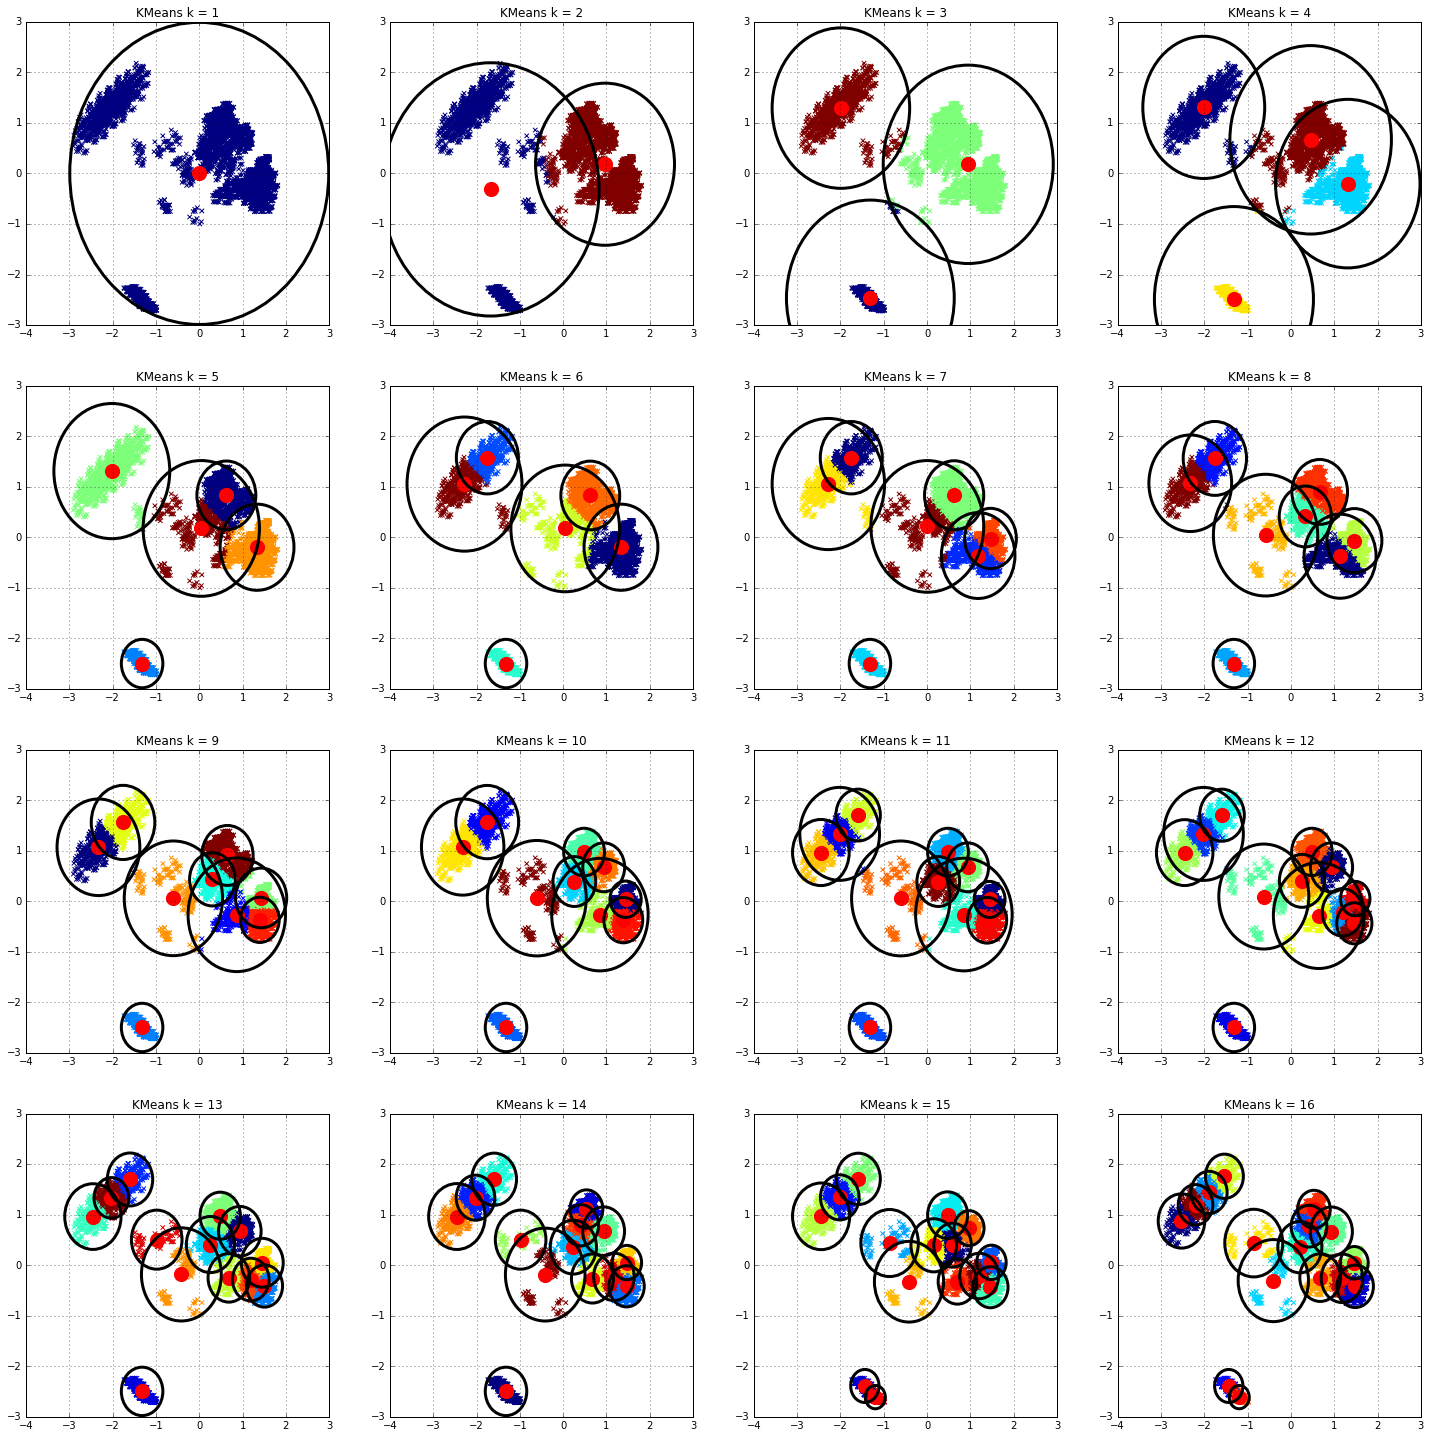

In [6]:
### P3 ###
def P3():
### STUDENT START ###
    #  Initiation of a 2D PCA 
    num_components = 2
    pca = PCA(n_components= num_components )
    
    #transform training data
    reduced_cartesian = pca.fit_transform(train_data)

    # Plot KMeans with [1,16] clusters over the 2d projected data
    plt.figure(figsize=(25,25))
    num_cluster =16
    for k in range (1, num_cluster+1):
        # Create kmean clusters
        kmeans = KMeans( init='k-means++', n_clusters= k)

        #Fit clusters with PCA transformed data
        clusters = kmeans.fit(reduced_cartesian) 

        # other plot setup
        plt.subplot(4, 4, k)
        plt.title('KMeans k = %d' %k)
        plt.grid(True)

        # First plot the scatterplot of 2D-PCA transformed coordinates and color them by clusters
        plt.scatter(reduced_cartesian[:,0], reduced_cartesian[:,1], c=clusters.labels_, marker="x")

        # Now let's plot cluster centroids
        plt.scatter(clusters.cluster_centers_[:,0], clusters.cluster_centers_[:,1], color='red', s = 200)

        # Now find out the furtherst point from each centroid and plot circles around centroids
        # Here k = clusters.cluster_centers_.shape[0]
        for x in range(0, k):
            # Euclidian distance Distance for the given cluster
            dist = np.linalg.norm(reduced_cartesian[clusters.labels_ == x] - clusters.cluster_centers_[x], axis=1)
           
            # maximum range
            r = dist.max()
            #  plug a circle that goes through the most distant point assigned to the cluster into existing plots
            plt.gcf().gca().add_artist(plt.Circle(xy=(clusters.cluster_centers_[x,0], clusters.cluster_centers_[x,1]), 
                                                  radius=r, fill=False, linewidth=3))
### STUDENT END ###
P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

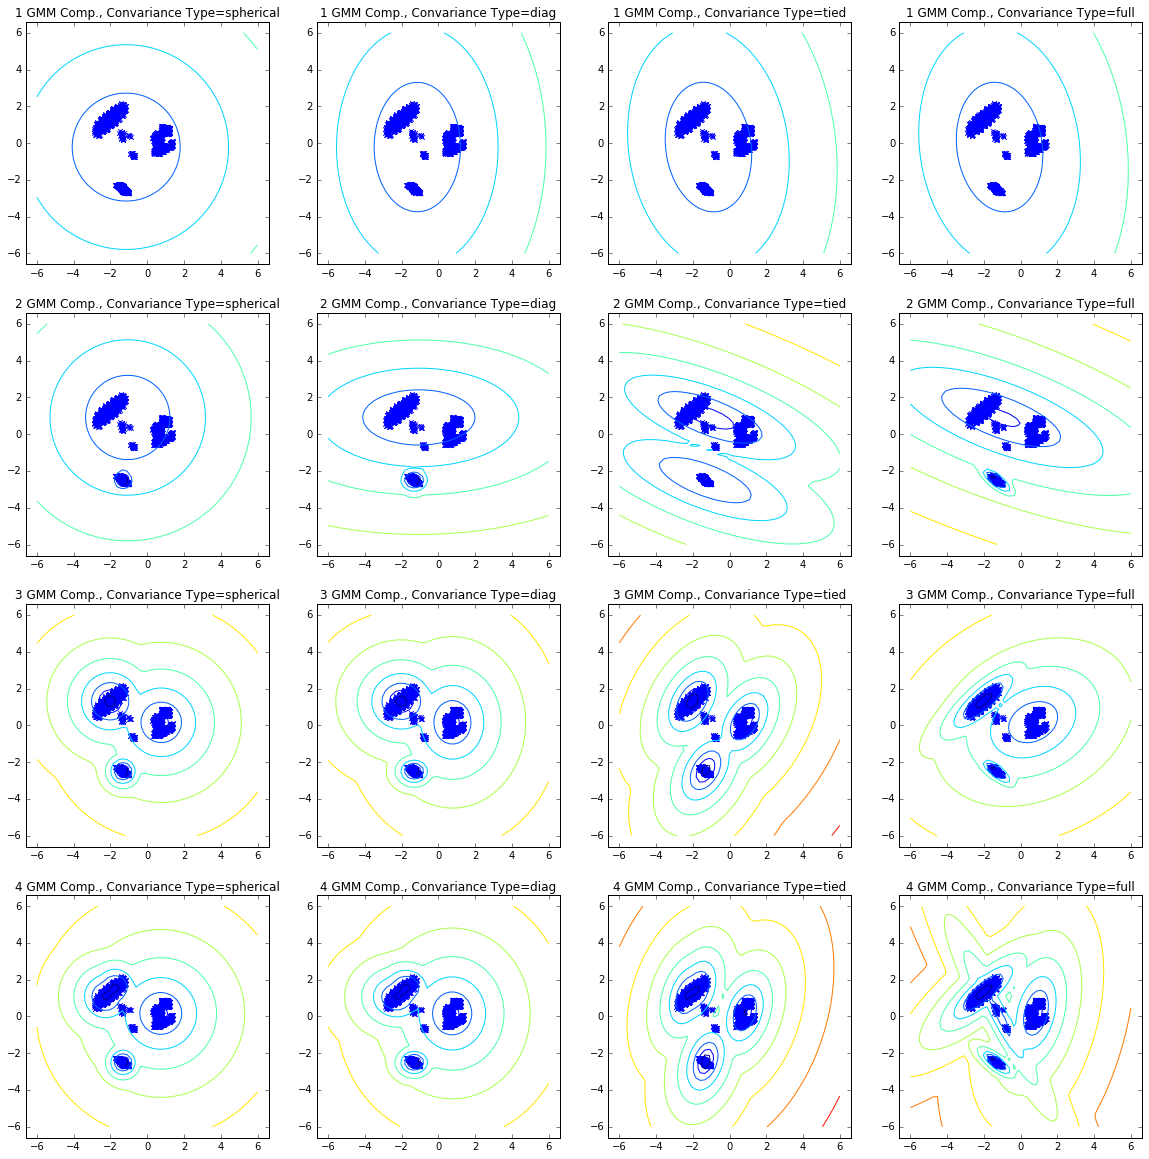

In [7]:
import warnings
warnings.filterwarnings("ignore")

def P4():
### STUDENT START ##

    # 2D-PCA transform training data and extract the postivive subset
    num_components = 2
    pca = PCA(n_components= num_components )
    reduced_cartesian = pca.fit_transform(train_data)
    reduced_cartesian_poison = reduced_cartesian[train_labels == 1]

    # Predefine covariance matrix types
    cov_matrix = ['spherical','diag','tied','full']
    
    figs, axes = plt.subplots(nrows=4, ncols=4, sharex=False, sharey=False, figsize = (20, 20))
    
    # Vary the number of mixture components from 1-4
    for i in range(0, 4):
        # Vary the covariance matrix type
        for idx, content in enumerate(cov_matrix):
            #Fit a GMM with i components and given covariance matrix for positive examples
            clf = GMM(n_components=(i+1), covariance_type = content)            
            clf.fit(reduced_cartesian_poison)

            # display predicted scores by contour plot
            x = np.linspace(-6.0, 6.0)
            y = np.linspace(-6.0, 6.0)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -clf.score_samples(XX)[0]
            Z = Z.reshape(X.shape)

            
            # Scatter plots for given GMM component and covariance matrix type   
            ax = axes[i, idx]
            ax.scatter(reduced_cartesian_poison[:,0], reduced_cartesian_poison[:,1], marker="x", c="blue")
            CS = ax.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
            #CB = plt.colorbar(CS, shrink=0.8, extend='both')
             
            #Title
            ax.set_title (str(i+1) + " GMM Comp., Convariance Type=" + cov_matrix[idx])
### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [8]:
import warnings
warnings.filterwarnings("ignore")

def P5():
### STUDENT START ###
    # 2D-PCA transform training data and extract the postivive and negative subsets
    pca = PCA(n_components= 2)
    T_train_data = pca.fit_transform(train_data)
    T_test_data = pca.transform(test_data)
    
    # Extract the positive and negative subsets
    example_labels = ['T_train_data_pos','T_train_data_neg']
    T_train_data_pos =  T_train_data[train_labels == 1]
    T_train_data_neg =  T_train_data[train_labels == 0]
    
    # Fit two 4-component full covariance GMM with positive and negative examples
    clf_pos = GMM(n_components=4, covariance_type = 'full')
    clf_pos.fit(T_train_data_pos)
    clf_neg = GMM(n_components=4, covariance_type = 'full')
    clf_neg.fit(T_train_data_neg)
    
    # Predict test examples by choosing the label giving a larger probability 
    correct = 0.0
    for i in range(len(test_labels)):
        # obtain GMM probability for each label
        pos_score = clf_pos.score([T_test_data[i]])[0]
        neg_score = clf_neg.score([T_test_data[i]])[0]
        # Count correctness and replace the prediction with the larger probability
        if pos_score >= neg_score:
            if test_labels[i] == 1:
                correct += 1
        else:
            if test_labels[i] == 0:
                correct += 1
    
    # Derive the final accuracy         
    accuracy = correct / len(test_labels)
    print("The GMM model accuracy is %.3f." %accuracy)
### STUDENT END ###

P5()

The GMM model accuracy is 0.951.


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [30]:
import time
from IPython.core.display import clear_output
import pandas as pd

#  First define a function to estimate the total number of parameters for gievn components_pca, component_gmm and cov_matrix types
def num_params(component_pca, component_gmm, cov_matrix):
        if cov_matrix == 'spherical':
            # For covariance_type='spherical', num_parameters = 2*(component_pca+1)*component_gmm
            return (component_pca + 1) * component_gmm * 2
        elif cov_matrix == 'diag':
            # For covariance_type='diag', num_parameters = 2*(2*component_pca) * component_gmm
            return component_pca * component_gmm * 4
        elif cov_matrix == 'tied':
            # For covariance_type='tied', num_parameters =  2*(component_pca + component_gmm*(component_gmm -1)/2 )* component_gmm
            return (component_pca * component_gmm + component_pca*(component_pca- 1)/2) * 2
        else: 
            # For covariance_type='full', num_parameters = 2*(component_pca + component_gmm*(component_gmm +1)/2 )* component_gmm
            return (component_pca + (component_pca * (component_pca + 1) / 2)) * component_gmm * 2 



# Calculate the number of parameters for each PCA - GMM within [1,12]
pca_col, gmm_col = [], []
sph_col, diag_col, tied_col, full_col = [], [], [], []
for a in xrange(1,13):
    for b in xrange(1,13):
        pca_col.append(b)
        gmm_col.append(a)
        
        sph_col.append( num_params(b,a,'spherical') )
        diag_col.append( num_params(b,a,'diag') )
        tied_col.append( num_params(b,a,'tied') )
        full_col.append( num_params(b,a,'full') )

param_df = pd.DataFrame( {'pca': pca_col, 'gmm': gmm_col, 'spherical': sph_col, 
                          'diag': diag_col, 'tied': tied_col, 'full': full_col} )

_sp = param_df[param_df['spherical']<50][['pca', 'gmm', 'spherical']].rename(columns={'spherical': 'parameters'})
_sp['covariance'] = 'spherical'

_dg = param_df[param_df['diag']<50][['pca', 'gmm', 'diag']].rename(columns={'diag': 'parameters'})
_dg['covariance'] = 'diag'

_td = param_df[param_df['tied']<50][['pca', 'gmm', 'tied']].rename(columns={'tied': 'parameters'})
_td['covariance'] = 'tied'

_fu = param_df[param_df['full']<50][['pca', 'gmm', 'full']].rename(columns={'full': 'parameters'})
_fu['covariance'] = 'full'

# Let's print out total number of models with less than 50 parameters
models_df = pd.concat([_sp, _dg, _td, _fu], ignore_index=True)
print 'Total model combinations with less than 50 parameters:', models_df.shape[0] 
#print sum(models_df["covariance"] == 'full')


Total model combinations with less than 50 parameters: 141
20


In [31]:
# Now let's find out the best accuracy of those 141 models
def P6(models, verbose=True):
### STUDENT START ###
    # Status updates for verbose printing
    TEMPL = {'total': 'TOTAL: [{ch:<59}] {done}/141 -> Best accuracy: {acc:.2%}',
             'spherical': '\tSpherical: [{ch:<35}] {done}/49 -> Best accuracy: {acc:.2%}',
             'diag': '\n\t Diagonal: [{ch:<35}] {done}/35 -> Best accuracy: {acc:.2%}',
             'tied': '\t     Tied: [{ch:<29}] {done}/37 -> Best accuracy: {acc:.2%}',
             'full': '\t     Full: [{ch:<19}] {done}/20 -> Best accuracy: {acc:.2%}' }

    def get_bar(cov):
        ''' Returns the formatted progress bar'''
        if cov == 'total':
            d = sum(mod_done.itervalues())
            l = d / 2
            a = max(best_acc.itervalues())
        else:
            d = mod_done[cov]
            l = d
            a = best_acc[cov]
        return TEMPL[cov].format(ch='#'*l, done=d, acc=a)

    # Initialize progress bars
    best_acc = {'spherical': 0, 'diag': 0, 'tied': 0, 'full': 0} 
    mod_done = {'spherical': 0, 'diag': 0, 'tied': 0, 'full': 0}

    # We will buffer the PCA-transformed data for each dimension
    pca_transformed = {}

    # We will store accuracy and time in the dataframe
    accuracy_col = []
    time_col = []

    # Iterate through all possible models
    for i,row in models.iterrows():
        # unpack parameters
        _pca, _gmm, _cov = row['pca'], row['gmm'], row['covariance']

        ## PCA decomposition
        if _pca not in pca_transformed:  # check if buffered
            _st = time.time()  # time PCA-transformation for buffering

            # Fit and transform data to 2d
            pca = PCA(n_components=_pca)
            _data = pca.fit_transform(train_data)

            # Split by positive - negative
            pos_data = _data[train_labels==1,:]
            neg_data = _data[train_labels==0,:]

            # Transform test dataset
            test_trans = pca.transform(test_data)

            t_pca = time.time() - _st  # stop timer

            # Buffer datasets and time
            pca_transformed[_pca] = { 'pos_data': pos_data, 'neg_data': neg_data,
                                      'test_data': test_trans, 'time': t_pca}
        else:
            pos_data = pca_transformed[_pca]['pos_data']
            neg_data = pca_transformed[_pca]['neg_data']
            test_trans = pca_transformed[_pca]['test_data']
            t_pca = pca_transformed[_pca]['time']


        ## GMM models (positive model & negative model)
        _st = time.time()  # time GMM model and prediction
        gm_pos = GMM(n_components=_gmm, covariance_type=_cov)
        gm_pos.fit(pos_data)

        gm_neg = GMM(n_components=_gmm, covariance_type=_cov)
        gm_neg.fit(neg_data)

        t_gmm = time.time() - _st  # stop timer

        # Calculate accuracy
        predicted = (gm_pos.score(test_trans) > gm_neg.score(test_trans)).astype(np.uint8)
        accuracy = 1. * (predicted == test_labels).sum() / len(test_labels)

        # Record accuracy - time
        accuracy_col.append(accuracy)
        time_col.append( t_pca + t_gmm )

        ## PROGRESS BAR
        best_acc[_cov] = max(best_acc[_cov], accuracy)  # update best_accuracy
        mod_done[_cov] += 1

        if verbose and (i % 10 == 0 or i==117):
            status = '\n'.join( map(get_bar, ['total', 'diag', 'spherical', 'tied', 'full']) )
            clear_output()
            print status

    acc = max(best_acc.itervalues())
    cov = max(best_acc, key=best_acc.get).upper()
    print '\nDONE!  --> The best model was a {} covariance type with {:.3%} accuracy'.format(cov, acc)

    # Add accuracies and time elapsed to the models dataframe
    models_df['accuracy'] = accuracy_col
    models_df['time'] = time_col

    return models_df

### STUDENT END ###

models_df = P6(models_df)
# Print out the toal 5 accurate models and their paramters
models_df.sort_values('accuracy', ascending=False).head()

TOTAL: [######################################################################] 141/141 -> Best accuracy: 97.33%

	 Diagonal: [###################################] 35/35 -> Best accuracy: 95.02%
	Spherical: [#################################################] 49/49 -> Best accuracy: 97.33%
	     Tied: [#####################################] 37/37 -> Best accuracy: 96.80%
	     Full: [####################] 20/20 -> Best accuracy: 95.11%

DONE!  --> The best model was a SPHERICAL covariance type with 97.331% accuracy


,pca,gmm,parameters,covariance,accuracy,time
29,7,3,48,spherical,0.973310,0.109
34,5,4,48,spherical,0.967972,0.187
98,4,3,36,tied,0.967972,0.140
28,6,3,42,spherical,0.967972,0.110
27,5,3,36,spherical,0.966192,0.140
